In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [13]:
catsd = '/home/stephenportillo/gen_model_hack/greycats_32/'
N = 15747

In [14]:
def load_image(d):
    
    img = Image.open(d)
    img.load()
    data = np.asarray(img, dtype='int32')
    
    return data

In [15]:
catsdata = np.zeros((N, 32, 32))

In [16]:
for i in range(N):
    d = catsd + str(i+1) + '.jpg'
    catsdata[i] = load_image(d)

In [17]:
catsdata.max()

255.0

# Normalizing all images (0, 1)

In [18]:
catsdata = catsdata / 255.

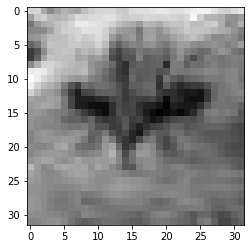

In [19]:
plt.imshow(catsdata[0], cmap='gray')

In [20]:
mydata = catsdata

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test = train_test_split(mydata, train_size=0.7, shuffle=True, random_state=42)

In [23]:
X_train.max(), X_test.max()

(1.0, 1.0)

In [24]:
# rescaling images
# a, b = 0.0, 1.0 
# X_train = (X_train - a) / (b-a)
# X_test = (X_test - a) / (b-a)

In [25]:
np.shape(X_train), np.shape(X_test)

((11022, 32, 32), (4725, 32, 32))

# Model building and training

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import SGD

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import datetime, os

In [28]:
# logsd = 'logs/fitting'

# board = TensorBoard(log_dir=logsd,histogram_freq=1,
#     write_graph=True,
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=2,
#     embeddings_freq=1)

In [29]:
encoder = Sequential()
encoder.add(Flatten(input_shape=[32,32])) 
encoder.add(Dense(400,activation="relu"))
encoder.add(Dense(200,activation="relu"))
encoder.add(Dense(100,activation="relu"))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(2))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               410000    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 515,452
Trainable params: 515,452
Non-trainable params: 0
__________________________________________________

In [31]:
2/(32*32)

0.001953125

In [32]:
decoder = Sequential()
decoder.add(Dense(50,input_shape=[2],activation='relu'))
decoder.add(Dense(100,activation='relu'))
decoder.add(Dense(200,activation='relu'))
decoder.add(Dense(400,activation='relu'))
decoder.add(Dense(32 * 32, activation="sigmoid"))
decoder.add(Reshape([32, 32]))

In [33]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_7 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_8 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              410624    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32)            0         
Total params: 516,474
Trainable params: 516,474
Non-trainable params: 0
________________________________________________

In [34]:
autoencoder = Sequential([encoder, decoder])

In [35]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 515452    
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32)            516474    
Total params: 1,031,926
Trainable params: 1,031,926
Non-trainable params: 0
_________________________________________________________________


In [36]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [38]:
autoencoder.fit(X_train, X_train, epochs=100000, validation_data=[X_test, X_test], callbacks=[early_stop])

Train on 11022 samples, validate on 4725 samples
Epoch 1/100000
11022/11022 [==============================] - 2s 216us/sample - loss: 0.0350 - acc: 0.0732 - val_loss: 0.0290 - val_acc: 0.0812
Epoch 2/100000
11022/11022 [==============================] - 2s 196us/sample - loss: 0.0287 - acc: 0.0959 - val_loss: 0.0281 - val_acc: 0.1017
Epoch 3/100000
11022/11022 [==============================] - 2s 189us/sample - loss: 0.0277 - acc: 0.1092 - val_loss: 0.0268 - val_acc: 0.1110
Epoch 4/100000
11022/11022 [==============================] - 2s 199us/sample - loss: 0.0280 - acc: 0.1036 - val_loss: 0.0283 - val_acc: 0.0908
Epoch 5/100000
11022/11022 [==============================] - 2s 189us/sample - loss: 0.0280 - acc: 0.1041 - val_loss: 0.0272 - val_acc: 0.1076
Epoch 6/100000
11022/11022 [==============================] - 2s 190us/sample - loss: 0.0277 - acc: 0.1103 - val_loss: 0.0269 - val_acc: 0.1143
Epoch 7/100000
11022/11022 [==============================] - 2s 197us/sample - loss: 0

In [39]:
# %tensorboard --logdir logs

# Evaluating model

In [40]:
losses = pd.DataFrame(autoencoder.history.history)

In [41]:
losses.columns

Index(['loss', 'acc', 'val_loss', 'val_acc'], dtype='object')

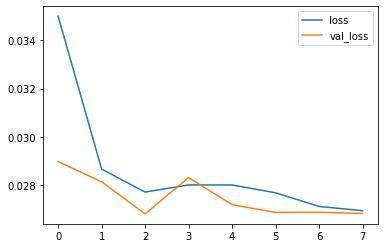

In [42]:
losses[['loss','val_loss']].plot()

In [43]:
autoencoder.evaluate(X_test, X_test), autoencoder.metrics_names

4725/4725 [==============================] - 0s 52us/sample - loss: 0.0268 - acc: 0.1116


([0.026822707137418172, 0.111640215], ['loss', 'acc'])

In [44]:
passed_images = autoencoder.predict(X_test)

In [45]:
np.shape(passed_images)

(4725, 32, 32)

2464


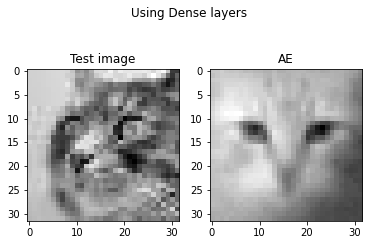

In [46]:
import random
n = random.randint(0, 4724)
print(n)

f = plt.figure()
f.add_subplot(1,2, 2)
plt.imshow(passed_images[n], cmap='gray')
plt.title('AE')

f.add_subplot(1,2, 1)
plt.imshow(X_test[n], cmap='gray')
plt.title('Test image')

plt.suptitle('Using Dense layers')
plt.show(block=True)


## Reconstruction metrics

In [47]:
def fnmse(yHat, y):
    return np.mean((yHat-y)**2)

def bCrossEntropy(yHat, y):
    return -np.mean(y*np.log(yHat) + (1-y)*np.log(1-yHat))

def cosinedist(yHat, y):
    
    u = yHat.flatten()
    v = y.flatten() 
    normu = np.sqrt(np.sum(u**2))
    normv = np.sqrt(np.sum(v**2)) 
    cosine_dist = np.dot(u, v) / (normu*normv)
    
    return 1 - cosine_dist

In [48]:
mse, bce, cd = 0, 0, 0
n_test = np.shape(X_test)[0]

for i in range(n_test):
    
    yHat, y = passed_images[i], X_test[i]
    
    mse += fnmse(yHat, y)
    bce += bCrossEntropy(yHat, y)
    cd += cosinedist(yHat, y)
    
print("Mean square error", mse/n_test)
print("Binary Crossentropy", bce/n_test)
print("Cosine distance", cd/n_test)

Mean square error 0.02682270611811599
Binary Crossentropy 0.6142292519099988
Cosine distance 0.07099778467775965


# Latent space visualization

In [49]:
latent_space = encoder.predict(X_test)

In [50]:
print(np.shape(latent_space))

(4725, 2)


Text(0.5, 1.0, 'Vanilla autoencoder; latent dim 2; lf mse')

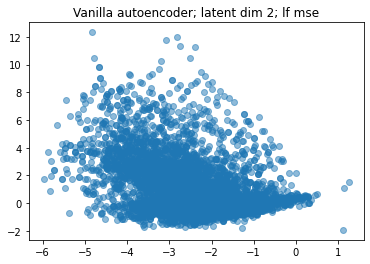

In [51]:
plt.scatter(latent_space[:,0], latent_space[:, 1], alpha=0.5)
plt.title('Vanilla autoencoder; latent dim 2; lf mse')

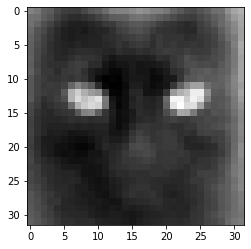

In [52]:
output = decoder.predict(latent_space)
plt.imshow(output[0], cmap='gray')

# Sampling from latent space

In [53]:
m = np.transpose(latent_space)
print(np.shape(m), np.cov(m))

(2, 4725) [[ 1.23580299 -0.87709317]
 [-0.87709317  4.18151831]]


In [54]:
np.mean(m, axis=1)

array([-2.5335233,  1.3147936], dtype=float32)

In [55]:
samples = np.random.multivariate_normal(np.mean(m, axis=1), np.cov(m), size=100)
print(samples.shape)

(100, 2)


In [56]:
randomsamples = decoder.predict(samples)

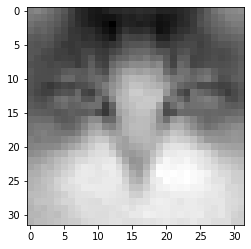

In [57]:
plt.imshow(randomsamples[0], cmap='gray')

In [58]:
for i in range(np.shape(randomsamples)[0]):
    name = 'fairsamples_ae_ls2/' + str(i) + '.jpeg'
    plt.imsave(name, randomsamples[i], cmap='gray')

# Image Quality metrics of Reconstructions or Fair Samples

In [9]:
# !pip install pybrisque

In [11]:
# import brisq
# brisq = BRISQUE()

# 2D grids of continuous change in latent space

In [105]:
def plot_cat_wall(fake_imgs, cmap='Greys', epoch='real'):
    fig, axis = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(fake_imgs[i, :, :], interpolation='bilinear',
                  cmap=cmap, origin='upper', 
                  aspect='equal')
        
    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('Gen Cats Vanilla autoencoder latent space 2d', fontsize=20, y=.95)
    plt.savefig('/home/lavanyanemani96/ae_ls2d.jpg')
    plt.show()

In [106]:
x = np.linspace(-5, 0, num=10, endpoint=True)
y = np.linspace(-2, 4, num=10, endpoint=True)

imagegrid = np.zeros((100, 32, 32))
c = 0

lsgrid = np.zeros((100, 2))
for i in x:
    for j in y:
        lsgrid[c, :] = [i, j]
        c = c+1

In [107]:
imagegrid = decoder.predict(lsgrid)

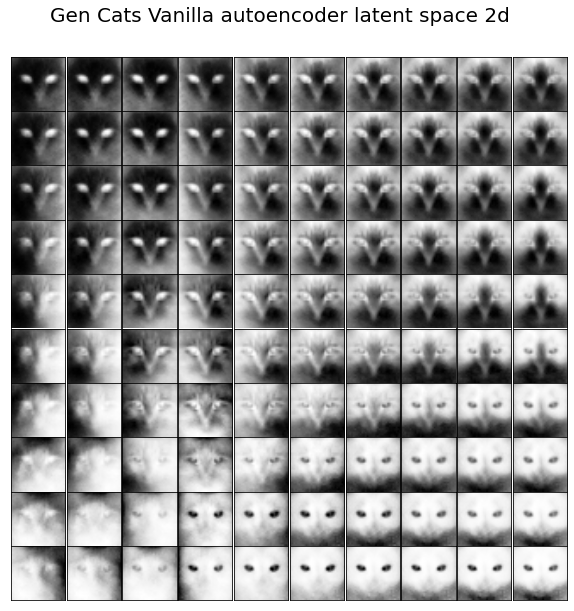

In [108]:
plot_cat_wall(imagegrid)